## Importing library

In [1]:
!pip install fuzzywuzzy

In [2]:
import numpy as np
import pandas as pd
import math
import time
import gc # 'garbage collection': controlling and managing the memory usage
import argparse # parsing command-line arguments in Python
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
# utils import
from fuzzywuzzy import fuzz
# for drawing the histograms
import matplotlib.pyplot as plt
import seaborn as sns
# for creating sparse matrices
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\kiett\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Importing data

In [3]:
ratings_data = pd.read_csv("~/Project/MovieLens_20M_Dataset/rating.csv")
ratings_data = ratings_data[:500000]
ratings_data_org = ratings_data
movies_data = pd.read_csv("~/Project/MovieLens_20M_Dataset/movie.csv")
df_movies = movies_data[['movieId', 'title']]

## Quick glance at the data

In [4]:
ratings_data_org

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
499995,3374,475,5.0,2000-09-15 02:19:45
499996,3374,480,3.0,2000-09-15 01:38:12
499997,3374,509,5.0,2000-09-15 02:02:45
499998,3374,541,5.0,2000-09-15 01:33:41


In [5]:
movies_data

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [6]:
#number of unique users and items
n_users = ratings_data.userId.unique().shape[0]
n_items = ratings_data.movieId.unique().shape[0]
print("Number of unique users: " + str(n_users))
print("Number of unique movies: " +str(n_items))

Number of unique users: 3374
Number of unique movies: 12277


## Preprocessing for Descriptive Statistics

In [8]:
# combining rating data with movie data
combined_data = pd.merge(ratings_data, movies_data, on='movieId')
combined_data.shape

(500000, 6)

In [9]:
# unsorted average ratings per movie
combined_data.groupby('userId')['rating'].mean().head()

userId
1    3.742857
2    4.000000
3    4.122995
4    3.571429
5    4.272727
Name: rating, dtype: float64

In [10]:
# sorted average ratings per movie
combined_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marriage Italian Style (Matrimonio all'italiana) (1964)    5.0
Fugitive Kind, The (1959)                                  5.0
Tokyo Joe (1949)                                           5.0
In Harm's Way (1965)                                       5.0
Hard to Be a God (2013)                                    5.0
Name: rating, dtype: float64

In [11]:
# sorted average ratings per movie with number of ratings (movies that are both often and highly rated)
combined_data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Pulp Fiction (1994)                 1684
Forrest Gump (1994)                 1667
Silence of the Lambs, The (1991)    1545
Shawshank Redemption, The (1994)    1532
Jurassic Park (1993)                1482
Name: rating, dtype: int64

In [12]:
# column of average rating of each movie
ratings_avg_count = pd.DataFrame(combined_data.groupby('title')['rating'].mean())
ratings_avg_count.head(10)

,rating
title,
$5 a Day (2008),3.000000
'Hellboy': The Seeds of Creation (2004),3.333333
'Neath the Arizona Skies (1934),3.500000
'Round Midnight (1986),3.666667
'Salem's Lot (2004),2.625000
'Til There Was You (1997),2.727273
"'burbs, The (1989)",3.089744
'night Mother (1986),3.642857
(500) Days of Summer (2009),3.728682


In [13]:
# column of number of ratings of that movie
ratings_avg_count['ratings_count'] = pd.DataFrame(combined_data.groupby('title')['rating'].count())
ratings_avg_count.head(10)

,rating,ratings_count
title,,
$5 a Day (2008),3.000000,1
'Hellboy': The Seeds of Creation (2004),3.333333,3
'Neath the Arizona Skies (1934),3.500000,1
'Round Midnight (1986),3.666667,3
'Salem's Lot (2004),2.625000,4
'Til There Was You (1997),2.727273,22
"'burbs, The (1989)",3.089744,78
'night Mother (1986),3.642857,7
(500) Days of Summer (2009),3.728682,129


In [14]:
# percentage of movies with less then 10 ratings
x = ratings_avg_count['ratings_count']
count = 0
for i in range(len(x)):
    if x[i] <= 10:
        count += 1
    perc_rat_10 = count * 100 / len(x)
print(perc_rat_10,"%")

59.71316818774446 %


In [15]:
# calculating the total counts of movies with no rating
df_ratings_count_temp = pd.DataFrame(ratings_data.groupby('rating').size(), columns=['count'])
print(df_ratings_count_temp.head(10))
total_count = n_users * n_items
rating_zero_count = total_count - ratings_data.shape[0]
print('rating_zero_count =', rating_zero_count)

         count
rating        
0.5       6822
1.0      17363
1.5       6517
2.0      34824
2.5      21158
3.0     108212
3.5      54828
4.0     141034
4.5      38958
5.0      70284
rating_zero_count = 40922598


In [16]:
# including 0 ratings
df_ratings_count = df_ratings_count_temp.append(pd.DataFrame({'count': rating_zero_count}, index=[0.0]),verify_integrity=True,).sort_index()
df_ratings_count

## 'verify_integrity=True' ensures that the resulting DataFrame has unique indices

,count
0.0,40922598
0.5,6822
1.0,17363
1.5,6517
2.0,34824
2.5,21158
3.0,108212
3.5,54828
4.0,141034
4.5,38958


In [17]:
# adding log count to make sure 0's are also included
df_ratings_count['log_count'] = np.log(df_ratings_count['count'])
df_ratings_count

,count,log_count
0.0,40922598,17.527193
0.5,6822,8.827908
1.0,17363,9.762097
1.5,6517,8.782169
2.0,34824,10.458062
2.5,21158,9.959773
3.0,108212,11.591848
3.5,54828,10.911956
4.0,141034,11.856756
4.5,38958,10.570239


In [18]:
# get rating frequency
df_movies_count = pd.DataFrame(ratings_data.groupby('movieId').size(), columns = ['count'])
df_movies_count

,count
movieId,
1,1238
2,553
3,311
4,57
5,325
...,...
128842,1
129354,1
129428,1


In [19]:
# pop_threshold should be smaller than act_threshold
# filtering the data (movies having rating count > threshold)

N = 50 #threshold
pop_movies = list(set(df_movies_count.query('count >= @N').index)) #'@N' represents a variable or value to be substituted.
ratings_data = ratings_data[ratings_data.movieId.isin(pop_movies)]
print(ratings_data)

        userId  movieId  rating            timestamp
0            1        2     3.5  2005-04-02 23:53:47
1            1       29     3.5  2005-04-02 23:31:16
2            1       32     3.5  2005-04-02 23:33:39
3            1       47     3.5  2005-04-02 23:32:07
4            1       50     3.5  2005-04-02 23:29:40
...        ...      ...     ...                  ...
499995    3374      475     5.0  2000-09-15 02:19:45
499996    3374      480     3.0  2000-09-15 01:38:12
499997    3374      509     5.0  2000-09-15 02:02:45
499998    3374      541     5.0  2000-09-15 01:33:41
499999    3374      589     5.0  2000-09-15 01:35:48

[407280 rows x 4 columns]


In [20]:
# get number of ratings given by every user
df_user_count = pd.DataFrame(ratings_data.groupby('userId').size(), columns = ['count'])
df_user_count

,count
userId,
1,141
2,46
3,174
4,28
5,66
...,...
3370,26
3371,67
3372,29


In [21]:
# filtering the data (users having rating count > threshold)

M = 50 #threshold
active_user = list(set(df_user_count.query('count >= @M').index))
ratings_data = ratings_data[ratings_data.userId.isin(active_user)]
print(ratings_data)

        userId  movieId  rating            timestamp
0            1        2     3.5  2005-04-02 23:53:47
1            1       29     3.5  2005-04-02 23:31:16
2            1       32     3.5  2005-04-02 23:33:39
3            1       47     3.5  2005-04-02 23:32:07
4            1       50     3.5  2005-04-02 23:29:40
...        ...      ...     ...                  ...
499984    3373    91529     4.5  2013-03-12 22:17:01
499985    3373    91542     4.0  2013-03-13 00:31:33
499986    3373    91658     4.5  2013-03-13 00:29:39
499987    3373    94959     5.0  2013-03-12 22:04:05
499990    3373    98809     4.5  2013-03-13 00:10:09

[365666 rows x 4 columns]


In [22]:
print('Original ratings data: ', ratings_data_org.shape)
print('Ratings data after excluding both unpopular movies and inactive users: ', ratings_data.shape)

Original ratings data:  (500000, 4)
Ratings data after excluding both unpopular movies and inactive users:  (365666, 4)


In [23]:
#updating row indices to avoid errors in data splitting process (where last row index = (shape of the data-1))
ratings_data = ratings_data.reset_index(drop=True)
ratings_data

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
365661,3373,91529,4.5,2013-03-12 22:17:01
365662,3373,91542,4.0,2013-03-13 00:31:33
365663,3373,91658,4.5,2013-03-13 00:29:39
365664,3373,94959,5.0,2013-03-12 22:04:05


## EDA

(0.0, 2000.0)

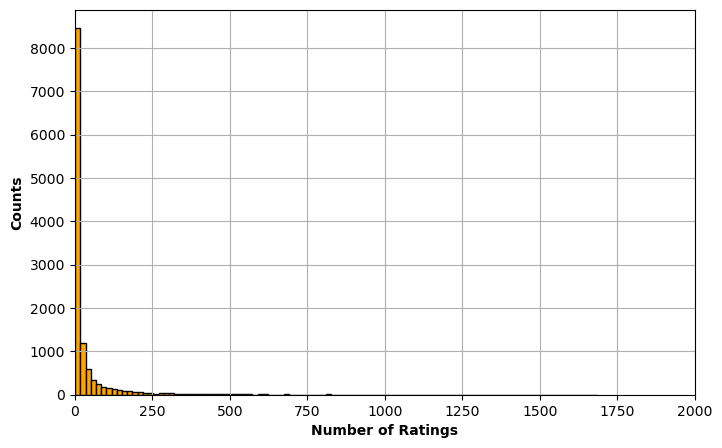

In [24]:
# Number of ratings counts
plt.figure(figsize=(8,5))
plt.rcParams['patch.force_edgecolor'] = True
ratings_avg_count['ratings_count'].hist(bins=100,color = 'orange')
plt.xlabel('Number of Ratings', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')
plt.xlim([0,2000])

Text(0, 0.5, 'Counts')

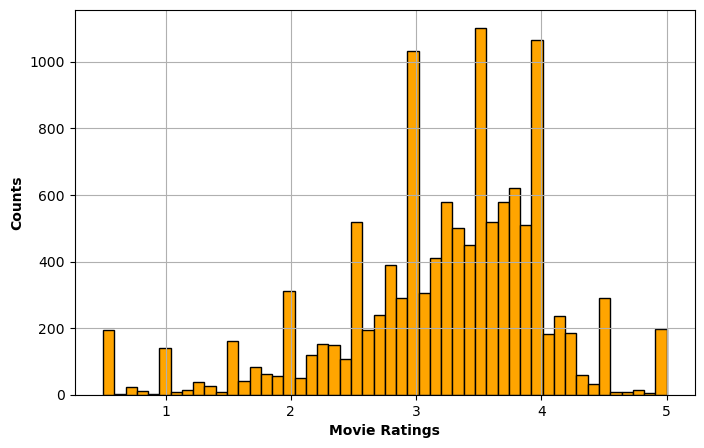

In [25]:
# Histogram of movie ratings
plt.figure(figsize=(8,5))
plt.rcParams['patch.force_edgecolor'] = True
ratings_avg_count['rating'].hist(bins=50, color = 'orange')
plt.xlabel('Movie Ratings', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')

<Figure size 800x1000 with 0 Axes>

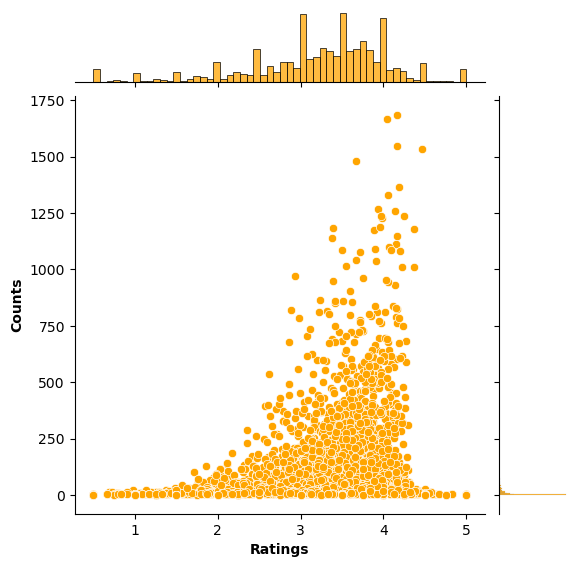

In [26]:
# Scatter plot of ratings and counts corresponding to those ratings
plt.figure(figsize=(8,10))
plt.rcParams['patch.force_edgecolor'] = True
figure = sns.jointplot(x='rating', y='ratings_count', data=ratings_avg_count, kind="scatter", color = 'orange')
plt.subplots_adjust(bottom=0.15, top=0.99, left=0.15)
figure.set_axis_labels("Ratings", "Counts", fontweight='bold')

Text(0, 0.5, 'Number of ratings')

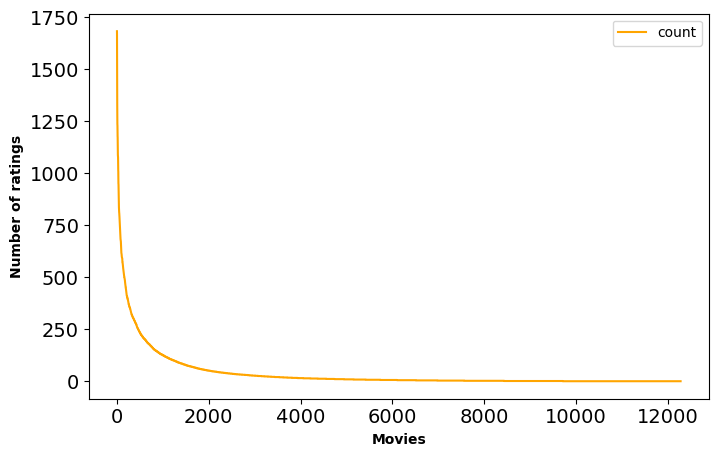

In [27]:
# rating frequency of all movies
ax = df_movies_count \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(figsize=(8, 5),fontsize=14,color = 'orange',)
ax.set_xlabel("Movies", fontweight='bold')
ax.set_ylabel("Number of ratings", fontweight='bold')

Text(0, 0.5, 'Number of ratings (log scale)')

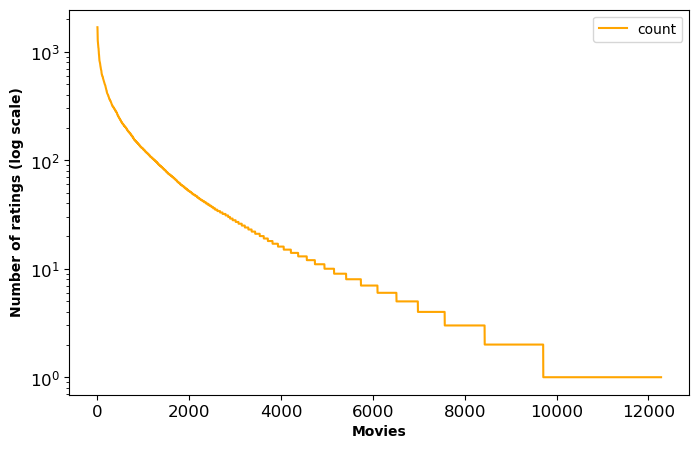

In [28]:
# plot rating frequency of all movies in log scale
ax = df_movies_count \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(figsize=(8, 5),fontsize=12,logy=True,color = 'Orange')
ax.set_xlabel("Movies", fontweight='bold')
ax.set_ylabel("Number of ratings (log scale)", fontweight='bold')

Text(0, 0.5, 'Number of ratings')

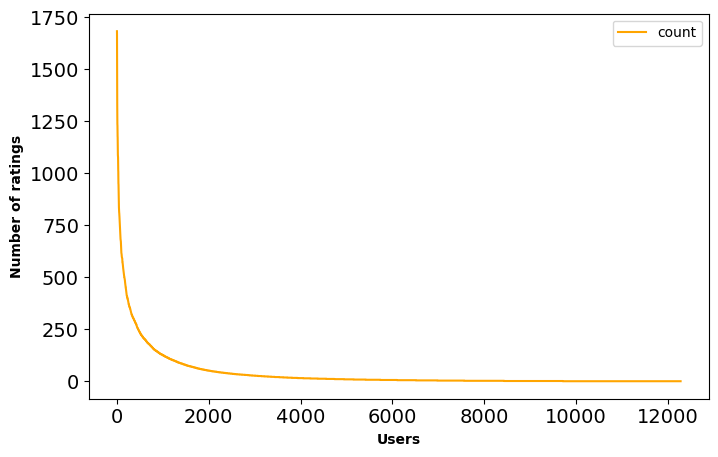

In [29]:
# plot rating frequency of all users
ax = df_movies_count \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(figsize=(8, 5),fontsize=14,color = 'orange')
ax.set_xlabel("Users", fontweight='bold')
ax.set_ylabel("Number of ratings", fontweight='bold')

## Creating functions

In [50]:
# creating User/Item/Rating sparse matrices matrices
def sparsematrix(data):
    # Getting the rating matrix
    n_users = data.userId.unique().shape[0]
    n_items = data.movieId.unique().shape[0]
    users_locations = data.groupby(by=['movieId', 'userId', 'rating']).apply(lambda x: 1).to_dict()
    row, col, value = zip(*(users_locations.keys()))
    map_u = dict(zip(data['movieId'].unique(), range(n_items)))
    map_l = dict(zip(data['userId'].unique(), range(n_users)))
    row_idx = [map_u[u] for u in row]
    col_idx = [map_l[l] for l in col]
    datar = np.array(value)
    sparse_csr = csr_matrix((datar, (row_idx, col_idx)), shape=(n_items, n_users))
    # coo_format_sparse = sparse_csr.tocoo([False])
    # csc_format_sparse = sparse_csr.tocsc([False])
    return(sparse_csr, data)

In [51]:
# splitting data
def get_data(data,test_size):
    unique_users = sorted(pd.unique(data['userId']))
    unique_items = sorted(pd.unique(data['movieId']))
    n_ratings = data.shape[0]
    test = []
    for userid in unique_users:
        # getting this users rating data
        dat = data[data['userId'] == userid]
        # sorting this users data based on time
        dat = dat.sort_values(['timestamp'], ascending=True)
        # test_size*100% of this users ratings
        num = int(dat.shape[0]*test_size)
        # selecting last num% of all ratings of this user
        indext = np.array(dat[-num:].index) ## '[-num:]': the index values of the last num rows
        test.append(indext)
    # (combining indices of all users) list containing the test element indices
    test = np.concatenate(test, axis=None)
    test_items = np.zeros(n_ratings, dtype=bool)
    test_items[test] = True
    test_df = data[['userId', 'movieId', 'rating']][test_items]
    train_df = data[['userId', 'movieId', 'rating']][~test_items]

    # determining the sparse user-item rating matrices in three formats using above datasets
    train_sparse_csr = sparsematrix(train_df)[0]
    test_sparse_csr = sparsematrix(test_df)[0]

    print("Size of the training set")
    print(len(train_df) / (len(train_df)+len(test_df)))
    print("Size of the test set")
    print(len(test_df) / (len(train_df)+len(test_df)))

    return(train_sparse_csr, test_sparse_csr, train_df, test_df)

In [52]:
## Matching the movies to the titles (title to lower case)
def fuzzy_mapper(movie_mapper, favorite_movie, bool = True):
    matches = []
    for title, index in movie_mapper.items():
        ratio = fuzz.ratio(title.lower(), favorite_movie.lower()) #calculate the similarity between the current movie and the favourite one
        if ratio>= 50:
            matches.append((title, index, ratio))
    # sorting the matches
    matches = sorted(matches, key = lambda x:x[2])[::-1]
    if not matches:
        print('There are no matches found')
        return
    if bool:
        print('Possible matches: {0}\n'.format([x[0] for x in matches]))
    return matches[0][1]

In [75]:
## Function making similar movie recommendation
def movie_RS(train_data, movie_mapper, favorite_movie, num_recom, distancesb = False):

    # defining the model: similarity, top N movies (n_jobs = -1: using all processors)
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=num_recom, n_jobs=-1)
    # fitting the model using sparse matrix based on the training data
    model_knn.fit(train_data)
    print('The name of the inserted (input) movie:', favorite_movie)
    # to transform the input movie to index
    index = fuzzy_mapper(movie_mapper, favorite_movie, bool=True)
    # because the first returned neighbor is always the target point itself, we add 1 to num_recom(neigbors)
    distances, indices = model_knn.kneighbors(train_data[index], num_recom + 1)
    rec_movies_indecies = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # transforming back to the movie names
    backward_mapper = {v: k for k, v in movie_mapper.items()}
    print('Recommendations for {}:'.format(favorite_movie))
    print('-----------------------------------------------')
    #list of movie indicies recommended for the target movie id
    rec_movie_ind = []
    if distancesb:
       for i, (index, dist) in enumerate(rec_movies_indecies):
            rec_movie_ind.append(index)
            print('{0}: {1}, with distances of {2}'.format(i + 1, backward_mapper[index], dist))
    else:
        for i, (index, dist) in enumerate(rec_movies_indecies):
            print('{0}: {1}'.format(i + 1, backward_mapper[index], dist))
            rec_movie_ind.append(index)

    # testing
    precisions = []
    n = len(test_df.userId.unique())
    for userid in test_df.userId.unique():
        movieids_peruser = []
        hits = 0
        for movieid in test_df[test_df['userId'] == userid]['movieId']:
            movieids_peruser.append(movieid)
        # is there a match between these movies and the recommended movies
        for elem in movieids_peruser:
            for recom in rec_movie_ind:
                if elem == recom:
                  # number of movies that are both in the recommended and test set for this user
                  hits+=1
        precision = hits/num_recom
        precisions.append(precision)
    print('The model precision with top {0} movie recommendations is: {1}'.format(num_recom,round(sum(precisions)/n,3)))

## Getting the sets and sparse matrices

In [54]:
data_object = get_data(ratings_data,0.3)
train_sparse_csr = data_object[0]
test_sparse_csr = data_object[1]
train_df = data_object[2]
test_df = data_object[3]
movie_user_matrix_train = train_df.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_matrix_test = test_df.pivot(index='movieId', columns='userId', values='rating').fillna(0)

Size of the training set
0.7023677344899444
Size of the test set
0.2976322655100556


In [55]:
data_object

(<2062x1983 sparse matrix of type '<class 'numpy.float64'>'
 	with 256832 stored elements in Compressed Sparse Row format>,
 <2062x1983 sparse matrix of type '<class 'numpy.float64'>'
 	with 108834 stored elements in Compressed Sparse Row format>,
         userId  movieId  rating
 1            1       29     3.5
 2            1       32     3.5
 3            1       47     3.5
 4            1       50     3.5
 5            1      112     3.5
 ...        ...      ...     ...
 365652    3373    78499     4.5
 365653    3373    79132     4.0
 365654    3373    79702     5.0
 365657    3373    84152     4.0
 365664    3373    94959     5.0
 
 [256832 rows x 3 columns],
         userId  movieId  rating
 0            1        2     3.5
 7            1      223     4.0
 14           1      367     3.5
 16           1      589     3.5
 21           1     1009     3.5
 ...        ...      ...     ...
 365660    3373    88129     4.0
 365661    3373    91529     4.5
 365662    3373    91542     

In [56]:
print(train_df)

        userId  movieId  rating
1            1       29     3.5
2            1       32     3.5
3            1       47     3.5
4            1       50     3.5
5            1      112     3.5
...        ...      ...     ...
365652    3373    78499     4.5
365653    3373    79132     4.0
365654    3373    79702     5.0
365657    3373    84152     4.0
365664    3373    94959     5.0

[256832 rows x 3 columns]


In [57]:
print(test_df)

        userId  movieId  rating
0            1        2     3.5
7            1      223     4.0
14           1      367     3.5
16           1      589     3.5
21           1     1009     3.5
...        ...      ...     ...
365660    3373    88129     4.0
365661    3373    91529     4.5
365662    3373    91542     4.0
365663    3373    91658     4.5
365665    3373    98809     4.5

[108834 rows x 3 columns]


## Experiment

In [93]:
movie_to_index = {
    movie: i for i, movie in
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_matrix_train.index].title))
}

favorite_movies = ['Babe','Copycat', '(500) Days of Summer ', '¡Three Amigos!', 'Things I Hate About You']
N = [3, 5, 10, 20, 30, 50]
for fav_movie in favorite_movies:
    for num_rec in N:
        print(fav_movie)
        print(num_rec)
        print(movie_RS(train_data = train_sparse_csr,favorite_movie = fav_movie, movie_mapper = movie_to_index, num_recom = num_rec, distancesb = False))

Babe
3
The name of the inserted (input) movie: Babe
Possible matches: ['Babe (1995)', 'Babel (2006)']

Recommendations for Babe:
-----------------------------------------------
1: Cutthroat Island (1995)
2: Clerks (1994)
3: Ace Ventura: When Nature Calls (1995)
The model precision with top 3 movie recommendations is: 0.025
None
Babe
5
The name of the inserted (input) movie: Babe
Possible matches: ['Babe (1995)', 'Babel (2006)']

Recommendations for Babe:
-----------------------------------------------
1: Demolition Man (1993)
2: Mighty Morphin Power Rangers: The Movie (1995)
3: Cutthroat Island (1995)
4: Clerks (1994)
5: Ace Ventura: When Nature Calls (1995)
The model precision with top 5 movie recommendations is: 0.018
None
Babe
10
The name of the inserted (input) movie: Babe
Possible matches: ['Babe (1995)', 'Babel (2006)']

Recommendations for Babe:
-----------------------------------------------
1: Dead Man Walking (1995)
2: Assassins (1995)
3: Seven (a.k.a. Se7en) (1995)
4: Othell

## Plotting graph for the first movie

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


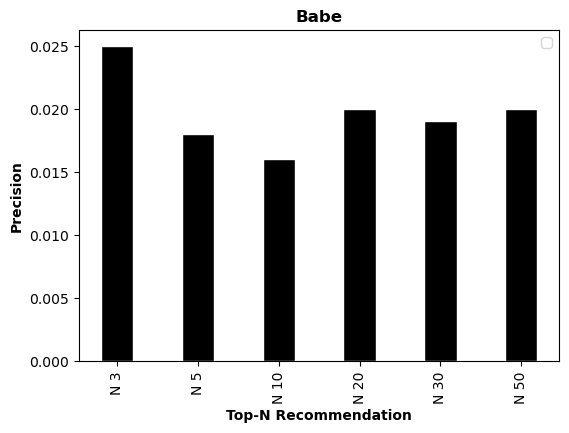

In [96]:
# Movie 1: Babe
# N = 3 0.025
# N = 5 0.018
# N = 10 0.016
# N = 20 0.02
# N = 30 0.019
# N = 50 0.02

bars = [0.025, 0.018, 0.016, 0.02, 0.019, 0.02]
# r1 = [1, 2, 3, 4, 5]
barWidth = 0.4
r1 = np.arange(len(bars))
r2 = [x + barWidth for x in r1]
plt.bar(r2, bars, color='black', width=barWidth, edgecolor='white')
plt.xlabel('Top-N Recommendation', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.title('Babe', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars))],['N 3', 'N 5', 'N 10', 'N 20', 'N 30','N 50'], rotation='vertical')
plt.subplots_adjust(bottom=0.23, top=0.92, left=0.15)
plt.legend()
plt.show()